In [1]:
import sys
sys.path.append("../../")

import numpy as np
from scipy.signal import find_peaks
import math
from typing import List
import logging

from didgelab.calc.conv import *
from didgelab.evo.nuevolution import GeoGenome, LossFunction
from didgelab.calc.geo import Geo
from didgelab.calc.sim.sim import get_log_simulation_frequencies, create_segments, compute_impedance
from didgelab.calc.sim.sim import create_segments, compute_impedance, get_notes
from didgelab.evo.nuevolution import Nuevolution, NumpyEncoder, LinearDecreasingCrossover, LinearDecreasingMutation, NuevolutionProgressBar, AdaptiveProbabilities

class WebShape(GeoGenome):

    def __init__(
        self,
        n_segments = 4, 
        d0=32, 
        d_bell_min=50, 
        d_bell_max=80,
        max_length = 1900, 
        min_length = 1500,
        n_bubbles=0,
        smoothness = 0.3):

        self.max_length = max_length
        self.min_length = min_length
        self.n_segments = n_segments
        self.d0 = d0
        self.d_bell_min = d_bell_min
        self.d_bell_max = d_bell_max
        self.n_bubbles = n_bubbles
        self.smoothness = smoothness
        
        self.bubble_width = 300
        self.bubble_height = 40

        self.geo_offset = 3 + self.n_bubbles*3
        genome_length = 3+2*(n_segments-1) + self.n_bubbles*3
        self.n_bubble_segments = 10

        GeoGenome.__init__(self, n_genes = genome_length)

    def get_properties(self):
        length = self.genome[0] * (self.max_length-self.min_length) + self.min_length
        bell_size = self.genome[1] * (self.d_bell_max - self.d_bell_min) + self.d_bell_min
        power = self.genome[2]*4

        bubbles = []
        j=3

        for i in range(self.n_bubbles):
            pos = self.bubble_width + self.genome[j] * (length-2*self.bubble_width)
            width = self.bubble_width*(0.2+self.genome[j+1])/1.2
            height = self.genome[j+2]*self.bubble_height
            j+=3
            bubbles.append((pos, width, height))
            
        x_genome = np.array([self.genome[i] for i in range(self.geo_offset, len(self.genome), 2)])
        y_genome = np.array([self.genome[i] for i in range(self.geo_offset+1, len(self.genome), 2)])

        return length, bell_size, power, x_genome, y_genome, bubbles

    def genome2geo(self):
        length, bell_size, power, x_genome, y_genome, bubbles = self.get_properties()

        x = np.arange(0, 1, 1/(self.n_segments+1)) * length
        y = np.arange(0, 1, 1/(self.n_segments+1))
        y = np.power(y, power)
        
        y = y * (bell_size-self.d0) + self.d0

        shift_x = length / self.n_segments
        x += np.concatenate(([0], (x_genome-0.5)*shift_x, [0]))

        shift_y = (1-self.smoothness)*bell_size
        y += np.concatenate(([0], (y_genome-0.5)*shift_y, [0]))

        x, y = self.fix_didge(x,y,self.d0, bell_size)

        for bubble in bubbles:
            pos, width, height = bubble
            x, y = self.make_bubble(x, y, pos, width, height)

        geo = list(zip(x,y))
        return Geo(geo)

    
    def fix_didge(self, x,y, d0, bellsize):
        mind = d0*0.9
        x=x.copy()
        y=y.copy()
        y[y<mind] = mind
        maxd = bellsize*1.3
        y[y>maxd] = maxd
        return x,y

    def make_bubble(self, x, y, pos, width, height):
        
        bubble_start_x = pos-0.5*width
        bubble_end_x = pos+0.5*width

        if bubble_start_x < 20:
            diff = 20-bubble_start_x
            bubble_start_x += diff
            bubble_end_x += diff

        if bubble_end_x > x[-1]:
            diff = bubble_end_x-x[-1]
            bubble_start_x -= diff
            bubble_end_x -= diff

        bubble_x = np.arange(bubble_start_x, bubble_end_x, (bubble_end_x-bubble_start_x)/self.n_bubble_segments)

        geo = Geo(list(zip(x,y)))
        bubble_y_1 = np.array([geo.diameter_at_x(i) for i in bubble_x])
        bubble_y_2 = height*np.sin(np.pi*np.arange(self.n_bubble_segments)/self.n_bubble_segments)
        bubble_y = bubble_y_1 + bubble_y_2

        y = np.concatenate((y[x<bubble_start_x], bubble_y, y[x>bubble_end_x]))
        x = np.concatenate((x[x<bubble_start_x], bubble_x, x[x>bubble_end_x]))

        return x, y

In [22]:
from didgelab.calc.conv import note_to_freq, freq_to_note, note_name, freq_to_note_and_cent
import pandas as pd

base_note=-31
base_freq = note_to_freq(base_note)
target_freqs = []
freq = base_freq
i=1

notes = []
cent_diffs = []
while freq < 1000:
    target_freqs.append(freq)
    i+=1
    freq = base_freq*i
    note, cent = freq_to_note_and_cent(freq)
    notes.append(note_name(note))
    cent_diffs.append(cent)

target_freqs = np.array(target_freqs)
df = pd.DataFrame( {"freq": target_freqs, "note": notes, "cent_diff": cent_diffs})
df.round(2)

,freq,note,cent_diff
0,73.42,D3,-0.00
1,146.83,A3,1.96
2,220.25,D4,-0.00
3,293.66,F#4,-13.69
4,367.08,A4,1.96
5,440.50,C5,-31.17
6,513.91,D5,-0.00
7,587.33,E5,3.91
8,660.75,F#5,-13.69
9,734.16,G#5,-48.68


In [49]:

class TairuaLoss(LossFunction):

    def __init__(self, 
                 target_freqs : List[float], 
                 target_impedances : List[float], 
                 freq_weights : List[float], 
                 impedance_weights : List[float], 
                 scale_key : int=None, 
                 scale : List[int] =None, 
                 scale_weight : float =None, 
                 higher_peaks = False,
                 higher_peaks_weight = 1,
                 more_peaks = False,
                 more_peaks_weight = 1,
                 max_error=5):
        
        self.target_freqs : List[float] = np.log2(target_freqs)
        self.target_impedances : List[float] = target_impedances
        self.freq_weights : List[float] = freq_weights
        self.impedance_weights : List[float] = impedance_weights
        self.max_error : float = 5
        self.freqs : List[float] = get_log_simulation_frequencies(1, 1000, max_error)
        self.scale : int = scale
        self.scale_key : List[int] = scale_key
        self.scale_weight : float = scale_weight
        self.higher_peaks = higher_peaks
        self.higher_peaks_weight = higher_peaks_weight
        self.more_peaks = more_peaks
        self.more_peaks_weight = more_peaks_weight    

        self.tune_to_scale = False
        if self.scale != None:
            self.scale_freqs : List[float] = self.compute_scale_frequencies()
            self.tune_to_scale = True
    
    # compute the frequencies of all notes of the given scale
    def compute_scale_frequencies(self):
        scale_freqs = []
        freq = -1
        i=0
        while freq<1000:
            f1 = math.floor(i/len(self.scale))
            f2 = i%len(self.scale)
            note = self.scale_key + 12*f1 + self.scale[f2]
            freq = note_to_freq(note)
            i += 1
            scale_freqs.append(freq)

        scale_freqs = np.log2(scale_freqs)
        return scale_freqs

    def loss(self, shape):
        if "loss" in shape.__dict__.keys() and shape.loss is not None:
            return shape.loss
        try:
            geo = shape.genome2geo()
            segments = create_segments(geo)
            impedances = compute_impedance(segments, self.freqs)
            peaks = find_peaks(impedances)

            peak_freqs = np.array([self.freqs[i] for i in peaks[0]])
            peak_freqs = np.log2(peak_freqs)
            peak_impedances = [impedances[i] for i in peaks[0]]
            peak_impedances = np.array(peak_impedances) / impedances.max()

            # compute deviation from tuning table
            freq_loss = []
            imp_loss = []
            for target_freq, target_impedance in zip(self.target_freqs, self.target_impedances):
                i = np.argmin(np.abs(peak_freqs - target_freq))
                peak_freq = peak_freqs[i]
                peak_impedance = peak_impedances[i]
                diff_freq = cent_diff(target_freq, peak_freq) / 600
                freq_loss.append(np.abs(diff_freq))

                if target_impedance >= 0:
                    diff_impedance = np.abs(peak_impedance - target_impedance)
                    imp_loss.append(diff_impedance)
    
            freq_loss = np.abs(freq_loss)
            freq_loss = np.sum(freq_loss * self.freq_weights)

            imp_loss = np.abs(imp_loss)

            imp_loss = np.sum(imp_loss * self.impedance_weights)

            losses = {
                "freq_loss": freq_loss,
                "imp_loss": imp_loss
            }

            # compute deviation from scale
            if self.tune_to_scale:
                i = [np.argmin(np.abs(self.scale_freqs-freq)) for freq in peak_freqs]
                diffs = np.abs(peak_freqs - self.scale_freqs[i])
                scale_losses = diffs.sum() * self.scale_weight / len(diffs)
                scale_losses *= 10
                losses["scale_losses"] = scale_losses

            if self.more_peaks:
                losses["more_peaks_loss"] = self.more_peaks_weight/len(peaks)

            if self.higher_peaks:
                losses["higher_peaks_loss"] = self.higher_peaks_weight/np.mean(peak_impedances)

            losses["total"] = sum(losses.values())

            return losses
        except Exception as e:
            logging.exception(e)
            return {
                "total": 100000000,
                "tuning_losses": np.array([-1]*len(self.target_freqs)),
                "scale_losses": np.array([-1]*len(self.target_freqs))
            }
        
from didgelab.evo.nuevolution import Nuevolution

freq_weights = np.ones(len(target_freqs))
freq_weights[0] *= 5

imp_weights = np.ones(len(target_freqs))
imp_weights[0] *= 5
imp_weights *= 0.1

target_impedances = 0.3*np.ones(len(target_freqs))
target_impedances[0] = 1
target_impedances[1] = 0.9
target_impedances[2] = 0.7
target_impedances[3] = 0.5
target_impedances[4] = 0.5

loss = TairuaLoss(
    target_freqs, 
    target_impedances,
    freq_weights,
    imp_weights
    #higher_peaks=True,
    #higher_peaks_weight=3.0,
    #more_peaks=True,
    #more_peaks_weight=15.0
)

shape = WebShape(n_segments=32, smoothness=0.6, n_bubbles=0)

loss.loss(shape)

{'freq_loss': 1.3752027838708396,
 'imp_loss': 0.26295243863258044,
 'total': 1.63815522250342}

In [51]:
from didgelab.util.didge_visualizer import DidgeVisualizer
import matplotlib.pyplot as plt
from datetime import datetime
import os
from time import time
import gzip
import json
from IPython.display import clear_output

class EvolutionMonitor:

    def __init__(self, target_freqs : np.array, loss : LossFunction):
        self.target_freqs = target_freqs
        self.losses = []
        self.loss = loss

    def evolution_monitor_callback(self, i_generation, population):

        loss_value = self.loss.loss(population[0])
        self.losses.append(loss_value["total"])

        geo = population[0].genome2geo()
        segments = create_segments(geo)
        freqs = get_log_simulation_frequencies(1, 1000, 5)
        impedances = compute_impedance(segments, freqs)

        notes = get_notes(freqs, impedances, target_freqs=self.target_freqs)
        clear_output()

        print()

        print(f"Generation {i_generation}")

        loss_str = {key:value.round(2) for key, value in loss_value.items()}
        print(f"losses: {loss_str}")
        print(notes.round(2))

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))
        ax1.plot(freqs, impedances)
        ax1.set_title("Impedance plot")

        DidgeVisualizer.vis_didge(geo, ax=ax2)
        ax2.set_title("bore")

        ax3.plot(range(len(self.losses)), self.losses)
        ax3.set_title("loss")

        plt.show()

class SaveEvolution:

    def __init__(self, output_dir = "outputs"):
        self.output_dir = output_dir
        current_datetime = datetime.now()
        iso_format_string = current_datetime.isoformat()
        self.outfile = os.path.join(self.output_dir, iso_format_string + ".json.gz")
        self.start_time = time()

    def evolution_monitor_callback(self, i_generation, population):

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        log_message = {
            "population": [p.genome.tolist() for p in population],
            "losses": [p.loss for p in population],
            "i_generation": i_generation,
            "loss0": population[0].loss,
            "time_elapsed": time() - self.start_time
        }

        with gzip.open(self.outfile, "wb") as f:
            log_message = json.dumps(log_message).encode('utf-8')
            f.write(log_message)

def init_standard_evolution(target_freqs, evo):

    schedulers = [
        LinearDecreasingCrossover(),
        LinearDecreasingMutation()
    ]

    AdaptiveProbabilities()

    monitor = EvolutionMonitor(target_freqs, evo.loss)
    se = SaveEvolution()
    def evolution_monitor_callback(i_generation, population):
        monitor.evolution_monitor_callback(i_generation, population)
        se.evolution_monitor_callback(i_generation, population)

    evo.callback_generation_ended = evolution_monitor_callback

def load_latest_evolution(output_folder = "outputs"):
    files = os.listdir(output_folder)
    files = sorted(files)
    infile = os.path.join(output_folder, files[-1])
    population = []
    with gzip.open(infile, "rb") as f:
        x = f.read().decode("utf-8")
        x = json.loads(x)

        for i in range(len(x["population"])):
            ind = shape.clone()
            ind.genome = np.array(x["population"][i])
            ind.loss = x["losses"][i]
            population.append(ind)
        return population

initial_population = shape.clone()
initial_population = load_latest_evolution()

evo = Nuevolution(
    loss, 
    initial_population,
    generation_size=100, 
    num_generations=50, 
    population_size=1000)

init_standard_evolution(target_freqs, evo)

population = evo.evolve()


Generation 1


AttributeError: 'float' object has no attribute 'round'


Generation 10
losses: {'tuning_losses': 119.39, 'total': 119.39}
  note_name  cent_diff  note_nr    freq  impedance  rel_imp        target
0        C2     -32.63      -33   64.19      27.96     1.00  D2 (-232.63)
1       F#3     -47.63      -15  179.98      18.43     0.66  D3 (+352.37)
2       C#4     -12.63       -8  275.17       8.75     0.31  D4 (-112.63)
3       F#4      42.37       -3  379.16       1.37     0.05  F#4 (+56.05)
4        B4      32.37        2  503.20       8.79     0.31   C5 (-36.46)
5       D#5       2.37        6  623.11      10.18     0.36  D5 (+102.37)
6        G5     -17.63       10  776.05       0.67     0.02  G#5 (-68.95)
7       G#5     -27.63       11  817.46       0.82     0.03  G#5 (+21.05)
8       A#5      27.37       13  947.18       6.58     0.24  A#5 (-13.16)


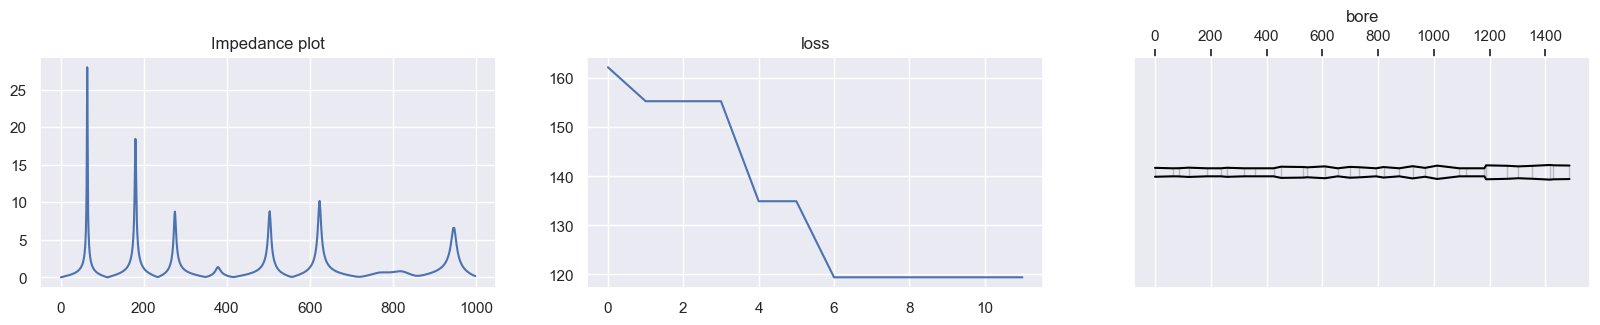

In [ ]:
class EvolutionMonitor:

    def __init__(self, target_freqs : np.array, loss : LossFunction):
        self.target_freqs = target_freqs
        self.losses = []
        self.loss = loss

    def evolution_monitor_callback(self, i_generation, population):

        loss_value = self.loss.loss(population[0])
        self.losses.append(loss_value["total"])

        geo = population[0].genome2geo()
        segments = create_segments(geo)
        freqs = get_log_simulation_frequencies(1, 1000, 5)
        impedances = compute_impedance(segments, freqs)

        notes = get_notes(freqs, impedances, target_freqs=self.target_freqs)
        clear_output()

        print()

        print(f"Generation {i_generation}")

        loss_str = {key:value.round(2) for key, value in loss_value.items()}
        print(f"losses: {loss_str}")
        print(notes.round(2))

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))
        ax1.plot(freqs, impedances)
        ax1.set_title("Impedance plot")

        for key in self.losses.keys():
            ax2.plot(range(len(self.losses)), [l[key] for l in self.losses])
            ax2.set_title("loss")

        DidgeVisualizer.vis_didge(geo, ax=ax3)
        ax3.set_title("bore")

        plt.show()



monitor = EvolutionMonitor(target_freqs, loss)
monitor.losses = _losses
monitor.evolution_monitor_callback(10, evo.population)

,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,C#2,37.368344,-32,70.807650,23.862184,1.000000
1,F3,37.368344,-16,178.424098,15.405708,0.645612
2,D4,-22.631656,-7,289.850802,5.477306,0.229539
3,F#4,2.368344,-3,370.500925,9.325683,0.390814
4,B4,-42.631656,2,481.869942,3.681722,0.154291
5,D#5,-17.631656,6,615.948818,0.913254,0.038272
6,F#5,22.368344,9,749.611876,4.548918,0.190633
7,A#5,-47.631656,13,907.025940,3.597249,0.150751


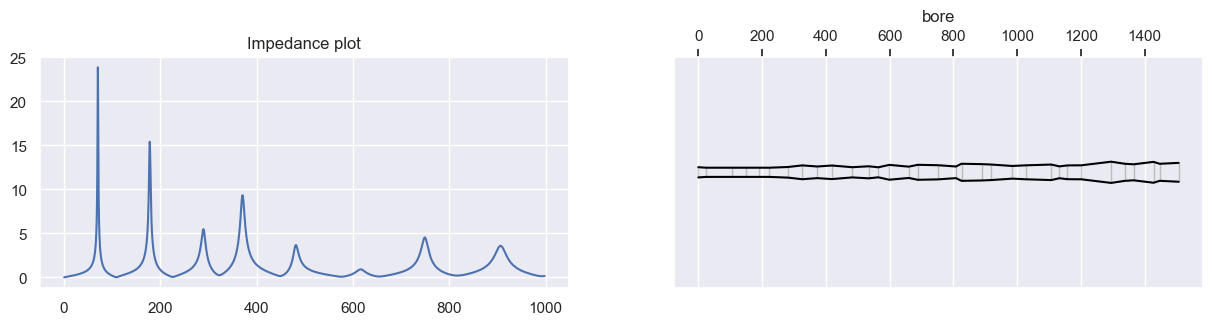

In [7]:
from didgelab.util.didge_visualizer import DidgeVisualizer
import matplotlib.pyplot as plt

geo = population[0].genome2geo()
segments = create_segments(geo)
freqs = get_log_simulation_frequencies(1, 1000, 5)
impedances = compute_impedance(segments, freqs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
ax1.plot(freqs, impedances)
ax1.set_title("Impedance plot")

DidgeVisualizer.vis_didge(geo, ax=ax2)
ax2.set_title("bore")

notes = get_notes(freqs, impedances)
notes

In [40]:
notes = get_notes(freqs, impedances)
targets = []
diffs = []
for freq in notes.freq:
    i = np.argmin(np.abs(freq-target_freqs))
    target = target_freqs[i]
    target_note = note_name(freq_to_note(target))
    cent = cent_diff(target, freq)
    sign = "+" if cent>0 else ""
    cent = f"{sign}{cent:.2f}"
    targets.append(f"{target_note} ({cent})")


notes["target"] = targets

notes.round(2)

,note_name,cent_diff,note_nr,freq,impedance,rel_imp,target
0,D#2,-17.63,-30,76.99,18.00,1.00,D2 (+82.37)
1,E3,37.37,-17,168.41,10.25,0.57,D3 (+237.37)
2,D4,7.37,-7,294.92,7.57,0.42,D4 (+7.37)
3,G4,-17.63,-2,388.02,8.25,0.46,F#4 (+96.05)
4,C#5,-27.63,4,545.59,5.51,0.31,C5 (+103.54)
5,D#5,-7.63,6,619.52,1.15,0.06,D5 (+92.37)
6,G5,-7.63,10,780.54,10.38,0.58,G#5 (-58.95)
7,A5,12.37,12,886.31,2.01,0.11,A5 (+10.41)


(1577.141906197692, 67.65964411965251)
{'tuning_losses': 99.67022247828542, 'total': 99.67022247828542}


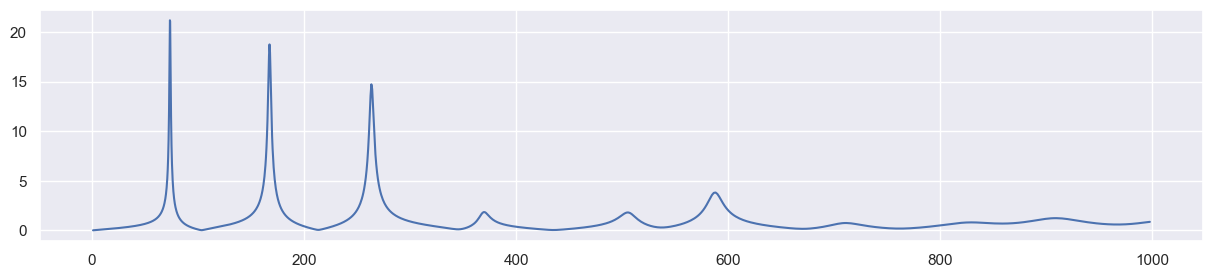

In [75]:
import matplotlib.pyplot as plt

geo = population[0].genome2geo()
segments = create_segments(geo)
freqs = get_log_simulation_frequencies(1, 1000, 5)
impedances = compute_impedance(segments, freqs)

print(geo.geo[-1])
print(loss.loss(population[0]))
get_notes(freqs, impedances)

plt.plot(freqs, impedances)
#ax.plot(freqs, impedances*2)
#ax1, ax2 = plt.subplots(1,2)
#ax1.line(freqs, impedances)
#plt.clf()
#DidgeVisualizer.vis_didge(geo)


<Axes: >

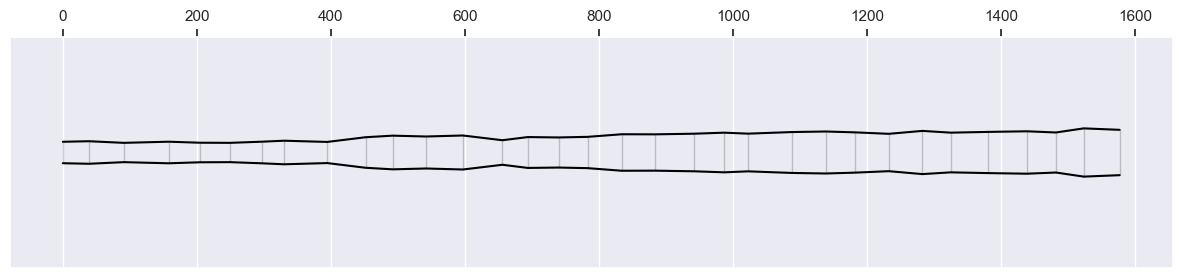

In [ ]:
from didgelab.util.didge_visualizer import DidgeVisualizer

DidgeVisualizer.vis_didge(geo)

In [72]:
evo = Nuevolution(
    loss,
    population,
    generation_size=100,
    num_generations=200,
    population_size=1000)

population2 = evo.evolve()

2025-07-17 20:05:02,391 [INFO] {nuevolution.py:479} Initialize Nuevolution
evolution_operator_probs: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
evolution_operators: ['RandomCrossover', 'AverageCrossover', 'SimpleMutation', 'SingleMutation', 'PartAverageCrossover', 'PartSwapCrossover']
evolution_parameters: {'mutation_rate': 0.25, 'gene_mutation_prob': 0.25, 'crossover_prob': -0.25}
father_genome: WebShape
generation_size: 100
loss: TairuaLoss
num_generations: 200
population_size: 1000
2025-07-17 20:05:02,397 [INFO] {nuevolution.py:491} initialize threadpoolexecutor with 8 workers
2025-07-17 20:05:02,399 [INFO] {nuevolution.py:505} compute initial generation





100%|██████████| 1000/1000 [00:00<00:00, 817603.12it/s]
best loss: 99.67: : 1123it [73:38:09, 81.86s/it]



















best loss: 97.04: : 1124it [73:38:37, 65.88s/it]



















best loss: 97.04: : 1125it [73:39:06, 54.69s/it]






(1604.3772449249093, 67.95666246319897)
{'tuning_losses': 87.27588857027331, 'total': 87.27588857027331}


,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,D2,2.368344,-31,73.516695,22.063896,1.000000
1,E3,-17.631656,-17,163.143760,19.988376,0.905931
2,C4,-22.631656,-9,258.227708,15.256028,0.691448
3,F#4,-7.631656,-3,368.366996,1.861454,0.084367
4,B4,22.368344,2,500.305904,1.575060,0.071386
5,D5,-7.631656,5,584.746158,3.008023,0.136332
6,F5,-7.631656,8,695.384291,0.860460,0.038999
7,G5,47.368344,10,805.737821,0.973721,0.044132
8,A5,22.368344,12,891.443777,1.088168,0.049319
9,B5,-37.631656,14,966.527296,0.605787,0.027456


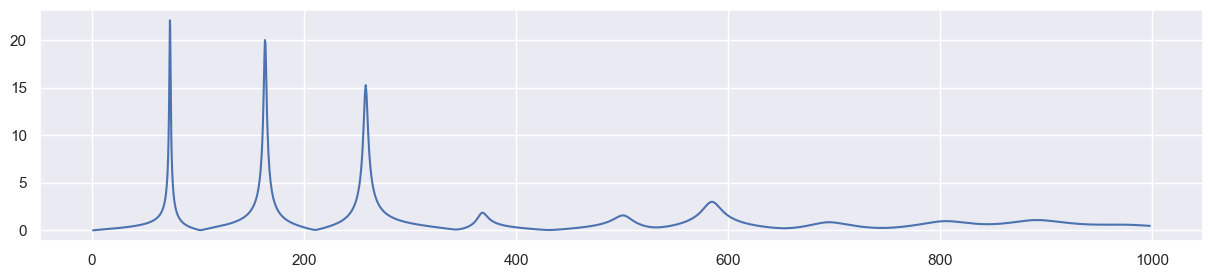

In [76]:
import matplotlib.pyplot as plt

geo = population2[0].genome2geo()
segments = create_segments(geo)
freqs = get_log_simulation_frequencies(1, 1000, 5)
impedances = compute_impedance(segments, freqs)

print(geo.geo[-1])
print(loss.loss(population2[0]))
plt.plot(freqs, impedances)
get_notes(freqs, impedances)

(1604.3772449249093, 67.95666246319897)


<Axes: >

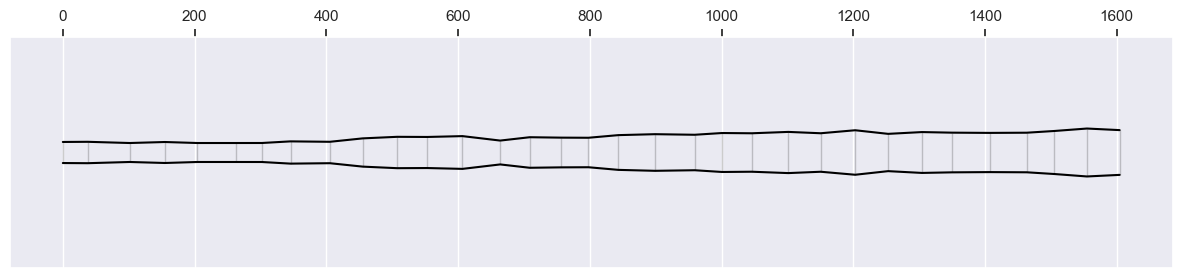

In [77]:
from didgelab.util.didge_visualizer import DidgeVisualizer

print(geo.geo[-1])
DidgeVisualizer.vis_didge(geo)

In [78]:
evo = Nuevolution(
    loss,
    population2,
    generation_size=100,
    num_generations=200,
    population_size=1000)

population3 = evo.evolve()

2025-07-18 17:39:22,661 [INFO] {nuevolution.py:479} Initialize Nuevolution
evolution_operator_probs: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
evolution_operators: ['RandomCrossover', 'AverageCrossover', 'SimpleMutation', 'SingleMutation', 'PartAverageCrossover', 'PartSwapCrossover']
evolution_parameters: {'mutation_rate': 0.25, 'gene_mutation_prob': 0.25, 'crossover_prob': -0.25}
father_genome: WebShape
generation_size: 100
loss: TairuaLoss
num_generations: 200
population_size: 1000
2025-07-18 17:39:22,663 [INFO] {nuevolution.py:491} initialize threadpoolexecutor with 8 workers
2025-07-18 17:39:22,665 [INFO] {nuevolution.py:505} compute initial generation





100%|██████████| 1000/1000 [00:00<00:00, 644682.45it/s]
best loss: 87.28: : 1323it [95:12:28, 12706.34s/it]



















best loss: 87.03: : 1324it [95:12:58, 8903.35s/it] 



















best loss: 87.03: : 1325it [95:13:26, 6240.85s/

In [79]:
loss = TairuaLoss(
    target_freqs, 
    target_impedances,
    target_weights,
    higher_peaks=True,
    higher_peaks_weight=1.0,
    more_peaks=True,
    more_peaks_weight=3.0
)
 
evo = Nuevolution(
    loss,
    population3,
    generation_size=100,
    num_generations=200,
    population_size=1000)

population4 = evo.evolve()

2025-07-18 19:50:58,055 [INFO] {nuevolution.py:479} Initialize Nuevolution
evolution_operator_probs: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
evolution_operators: ['RandomCrossover', 'AverageCrossover', 'SimpleMutation', 'SingleMutation', 'PartAverageCrossover', 'PartSwapCrossover']
evolution_parameters: {'mutation_rate': 0.25, 'gene_mutation_prob': 0.25, 'crossover_prob': -0.25}
father_genome: WebShape
generation_size: 100
loss: TairuaLoss
num_generations: 200
population_size: 1000
2025-07-18 19:50:58,064 [INFO] {nuevolution.py:491} initialize threadpoolexecutor with 8 workers
2025-07-18 19:50:58,064 [INFO] {nuevolution.py:505} compute initial generation





100%|██████████| 1000/1000 [00:00<00:00, 387285.69it/s]
best loss: 84.94: : 1523it [97:24:07, 32.53s/it]



















best loss: 84.94: : 1524it [97:24:39, 32.50s/it]



















best loss: 84.94: : 1525it [97:25:12, 32.52s/it]






(1604.0010671598814, 68.0484282331671)
{'tuning_losses': 87.27588857027331, 'total': 87.27588857027331}


,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,D2,2.368344,-31,73.516695,21.909904,1.000000
1,E3,-22.631656,-17,162.673262,19.718910,0.900000
2,C4,-27.631656,-9,257.482993,15.337381,0.700020
3,F#4,-12.631656,-3,367.304646,1.863190,0.085039
4,B4,27.368344,2,501.752933,1.518144,0.069290
5,D5,-7.631656,5,584.746158,3.010943,0.137424
6,F5,-7.631656,8,695.384291,0.906396,0.041369
7,G#5,-47.631656,11,808.068247,0.997077,0.045508
8,A5,22.368344,12,891.443777,0.941591,0.042976
9,A#5,42.368344,13,955.425783,0.658296,0.030046


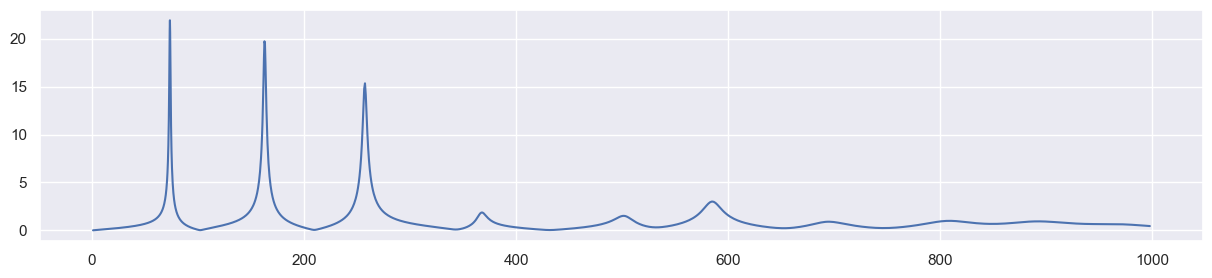

In [80]:
import matplotlib.pyplot as plt

geo = population3[0].genome2geo()
segments = create_segments(geo)
freqs = get_log_simulation_frequencies(1, 1000, 5)
impedances = compute_impedance(segments, freqs)

print(geo.geo[-1])
print(loss.loss(population2[0]))
plt.plot(freqs, impedances)
get_notes(freqs, impedances)